<a href="https://colab.research.google.com/github/TSHP/DL4SC_Neural_ODEs/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading in the MNIST DATASET

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import torch.nn as nn
from torch.nn import ReLU
from torch import optim
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot

In [2]:
mnistTrainSet = torchvision.datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transforms.ToTensor()) # might need to normalize
mnistTrainLoader = torch.utils.data.DataLoader(mnistTrainSet, batch_size=64,
                                      shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 123999258.09it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 97375959.67it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 90674053.34it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 12157325.31it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Constructing a 1 Layer MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(MLP, self).__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.Relu = ReLU()
    def forward(self, x):
        out = self.linear(x)
        out = self.Relu(out)
        return out

In [ ]:
batch_size = 64
in_dim, num_class = 28*28, 10

l_r = 0.0001
w_decay = 1e-4
model = MLP(in_dim, num_class)
optimizer = optim.Adam(model.parameters(), lr=l_r, weight_decay = w_decay)
criterion = nn.CrossEntropyLoss()

Train with 10 class probabilities

In [ ]:
total_steps = len(mnistTrainLoader)
epochs = 10
for cur_epoch in range(epochs):
  for x, (images, labels) in enumerate(mnistTrainLoader):
    images = images.reshape(-1, 28*28)

    out = model(images)

    losses = criterion(out, labels)

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    if (x+1) % 300 == 0:
      print (f'Epoch[{cur_epoch+1}/{epochs}], Step[{x+1}/{total_steps}], Losses: {losses.item():.4f}')
print(losses.item())

Dataloader Understanding

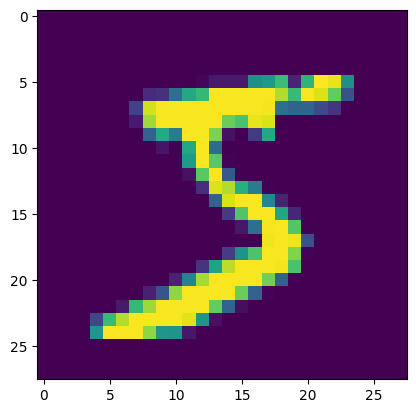

In [ ]:
plt.imshow(mnistTrainSet.data[0])
plt.show()

In [ ]:
for idx, batch in enumerate(mnistTrainLoader):
  print('Batch index: ', idx)
  print('Batch size: ', batch[0].size())
  print('Batch label: ', batch[1])
  break

In [ ]:
for idx, (data, target) in enumerate(mnistTrainLoader):
    print(data[0].shape)
    print(len(data))
    print(len(target))
    print(target[0])
    break

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out += identity
        out = self.relu(out)

        return out

# Define the ResNet model
class ResNet6(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        super(ResNet6, self).__init__()
        w = 32
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=w, kernel_size=3, stride=1),
            nn.BatchNorm2d(w),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=w, out_channels=w, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(w),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=w, out_channels=w, kernel_size=3, stride=2, padding=1),
        )
        self.residual_blocks = nn.Sequential(
            ResidualBlock(w, w),
            ResidualBlock(w, w),
            ResidualBlock(w, w),
            ResidualBlock(w, w),
            ResidualBlock(w, w),
            ResidualBlock(w, w)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(w, num_classes)

    def forward(self, x):

        out = self.downsample(x)

        out = self.residual_blocks(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [8]:
# Create an instance of the ResNet model
model_ResNet = ResNet6(in_channels=1)

# Define the training parameters
learning_rate = 0.001
num_epochs = 10
print_interval = 75

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ResNet.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    eval_counter = 0

    for i, (images, labels) in enumerate(mnistTrainLoader, 1):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_ResNet(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        eval_counter += 1

        # Print the running loss every 'print_interval' evaluations
        if eval_counter % print_interval == 0:
            average_loss = running_loss / print_interval
            print(f"Epoch [{epoch+1}/{num_epochs}], Evaluation [{i}/{len(mnistTrainLoader)}], Loss: {average_loss}")
            running_loss = 0.0
            eval_counter = 0

    # Print the remaining running loss at the end of the epoch
    if eval_counter > 0:
        average_loss = running_loss / eval_counter
        print(f"Epoch [{epoch+1}/{num_epochs}], Evaluation [{i}/{len(mnistTrainLoader)}], Loss: {average_loss}")

Epoch [1/10], Evaluation [75/938], Loss: 0.8359484553337098
Epoch [1/10], Evaluation [150/938], Loss: 0.24477165540059406


KeyboardInterrupt: ignored